In [1]:
%load_ext autoreload
%autoreload 2
%pip install prettytable
import warnings
import json

warnings.filterwarnings("ignore")
# import the necessary package
from baseline.OE_GPLVM.aeb_gplvm import AEB_GPLVM, NNEncoder, DataInput, DataOutput, Metrics, Parameters
from baseline.OE_GPLVM.train import *
from baseline.OE_GPLVM.utils import *
from gpytorch.likelihoods import GaussianLikelihood
from torch.distributions import kl_divergence
from gpytorch.priors import MultivariateNormalPrior
from utils.data_generator import DataGenerator
from utils.myutils import Utils
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import trange
plt.style.use("ggplot")
datagenerator = DataGenerator()  # data generator
utils = Utils()  # utils function

# dataset and model list / dict
dataset_list = [
    "01_ALOI",
    "02_annthyroid",
    "03_backdoor",
    "04_breastw",
    "05_campaign",
    "06_cardio",
    "07_Cardiotocography",
    "08_celeba",
    "09_census",
    "99_linear",
    "99_circles",
    "99_moons",
    "99_clusters",
]
dataset = dataset_list[-1]
datagenerator.dataset = dataset
labeled_anomalies = .1
data = datagenerator.generator(la=labeled_anomalies, realistic_synthetic_mode=None, noise_type=None)

Y_train = torch.tensor(data["X_train"], dtype=torch.float32)
Y_test = torch.tensor(data["X_test"], dtype=torch.float32)
lb_train = torch.tensor(data["y_train"], dtype=torch.float32)
lb_test = torch.tensor(data["y_test"], dtype=torch.float32)
ratio = data["y_test"].sum() / data["y_test"].shape[0]

experiment = Experiment(
    dataset,
    Y_train,
    Y_test,
    lb_train,
    lb_test,
    len(Y_train),
    Y_train.shape[-2],
    100,
    3,
    50,
    100,
    (5, 5),
    0.005,
    "loe",
    "hard",
)

N = experiment.N
data_dim = experiment.data_dim
latent_dim = experiment.latent_dim
n_inducing = experiment.n_inducing
n_epochs = experiment.n_epochs
nn_layers = experiment.nn_layers
lr = experiment.lr
method = experiment.method
elbo_type = experiment.elbo
batch_size = experiment.batch_size

#fig = plt.figure(figsize=(5, 5))
#plt.subplot(111)
#plt.scatter(
#    data["X_train"][:, 0][np.where(lb_train == 1)[0]],
#    data["X_train"][:, 1][np.where(lb_train == 1)[0]],
#    label="Anomaly",
#)
#plt.scatter(
#    data["X_train"][:, 0][np.where(lb_train == 0)[0]],
#    data["X_train"][:, 1][np.where(lb_train == 0)[0]],
#    label="Normal",
#    alpha=0.2,
#)
#plt.legend()


n_train = len(Y_train)
data_dim = Y_train.shape[1]
nn_layers = (5, 5)
n_inducing = 50
latent_dim = 2
lr = 0.01
X_prior_mean = torch.zeros(n_train, latent_dim)
X_prior_covar = torch.eye(X_prior_mean.shape[1])
prior_x = MultivariateNormalPrior(X_prior_mean, X_prior_covar)
encoder = NNEncoder(n_train, latent_dim, prior_x, data_dim, nn_layers)

model = AEB_GPLVM(
    n_train,
    data_dim,
    latent_dim,
    n_inducing,
    encoder,
    nn_layers,
)

likelihood = GaussianLikelihood()
optimizer = torch.optim.Adam(
    [
        {"params": model.parameters()},
        {"params": likelihood.parameters()},
    ],
    lr,
)


Note: you may need to restart the kernel to use updated packages.


2023-09-19 20:02:05.734866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 20:02:05.776003: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


generating duplicate samples for dataset 99_clusters...
current noise type: None
{'Samples': 1000, 'Features': 2, 'Anomalies': 64, 'Anomalies Ratio(%)': 6.4}


In [2]:
data_input = DataInput(
    X_train=data["X_train"].tolist(),
    X_test=data["X_test"].tolist(),
    lb_train=data["y_train"].tolist(),
    lb_test=data["y_test"].tolist(),
    ratio=ratio,
    labeled_anomalies=labeled_anomalies,
)

parameters = Parameters(
    nn_layers=nn_layers,
    nn_architeture="default",
    kernel="rbf",
    lr=0.01,
    epoch=1000,
    batch_size=128,
)

metrics = Metrics()
data_output = DataOutput()

In [3]:
def get_indices(y_train):
    idx_a = np.where(y_train == 1)[0]
    idx_n = np.where(y_train == 0)[0]
    ratio = len(idx_a) / (len(idx_a) + len(idx_n))
    qtd_anomaly = int(ratio * batch_size)
    qtd_normal = batch_size - qtd_anomaly
    idx_n = torch.tensor(np.random.choice(idx_n, qtd_normal, replace=True))

    if qtd_anomaly == 0:
        idx_a = torch.tensor(np.random.choice(idx_n, qtd_anomaly, replace=True))
    else:
        idx_a = torch.tensor(np.random.choice(idx_a, qtd_anomaly, replace=True))

    batch_index = torch.cat([idx_n, idx_a])

    return idx_n, idx_a, batch_index, ratio


def get_loe_index(X, indices):
    ll_0, klu_0, kl_0, _ = calculate_terms(X, indices)
    score = ll_0 - kl_0

    qtd_normal = int(score.shape[0] * (1 - ratio))
    qtd_anormal = batch_size - int(score.shape[0] * (1 - ratio))

    _, loe_idx_n = torch.topk(score, qtd_normal, largest=True, sorted=False)
    _, loe_idx_a = torch.topk(score, qtd_anormal, largest=False, sorted=False)
    return indices[loe_idx_n], indices[loe_idx_a]


def create_dist_qx(model, batch_target):
    mu = model.predict_latent(batch_target)[0]
    sigma = model.predict_latent(batch_target)[1]
    local_q_x = MultivariateNormal(mu, sigma)
    return mu, sigma, local_q_x


def create_dist_prior(
    batch_target,
    mu,
):
    local_p_x_mean = torch.zeros(batch_target.shape[0], mu.shape[1])
    local_p_x_covar = torch.eye(mu.shape[1])
    local_p_x = MultivariateNormalPrior(local_p_x_mean, local_p_x_covar)
    return local_p_x


def kl_divergence_variational(target):
    ll_shape = torch.zeros_like(target.T)
    klu = (
        ll_shape.T.add_(model.variational_strategy.kl_divergence().div(batch_size))
        .sum(-1)
        .T.div((n_train))
    )
    return klu


def calculate_terms(X, indices):
    batch_target = X[indices]
    mu, sigma, local_q_x = create_dist_qx(model, batch_target)
    local_p_x = create_dist_prior(batch_target, mu)
    batch_output = model(model.sample_latent_variable(batch_target))
    log_likelihood = (
        likelihood.expected_log_prob(batch_target.T, batch_output)
        .sum(0)
        .div(batch_size)
    )
    kl_x = kl_divergence(local_q_x, local_p_x).div(n_train)
    kl_u = kl_divergence_variational(batch_target)
    log_marginal = (
        likelihood.log_marginal(batch_target.T, batch_output).sum(0).div(batch_size)
    )
    return log_likelihood, kl_u, kl_x, log_marginal


def predict_score(X_test):
    n_test = len(X_test)
    mu, sigma, local_q_x = create_dist_qx(model, X_test)
    local_p_x = create_dist_prior(X_test, mu)
    X_pred = model(model.sample_latent_variable(X_test))
    exp_log_prob = likelihood.expected_log_prob(X_test.T, X_pred)
    log_likelihood = exp_log_prob.sum(0).div(n_test)
    kl_x = kl_divergence(local_q_x, local_p_x).div(n_test)
    kl_u = kl_divergence_variational(X_test)
    score = -(log_likelihood - kl_u - kl_x).detach().numpy()
    score = MinMaxScaler().fit_transform(np.reshape(score, (-1, 1)))
    return score

In [4]:
model.train()
iterator = trange(10000, leave=True)
for i in iterator:
    optimizer.zero_grad()
    _, _, batch_index, ratio = get_indices(lb_train)
    idx_n, idx_a = get_loe_index(Y_train, batch_index)

    ll_n, klu_n, kl_n, lm_n = calculate_terms(Y_train, idx_n)
    ll_a, klu_a, kl_a, lm_a = calculate_terms(Y_train, idx_a)
    loss_normal, loss_anomaly = (ll_n - klu_n - kl_n).sum(), (ll_a - klu_a - kl_a).sum()
    loss = -(loss_normal + loss_anomaly).sum()
    metrics.loss_normal.append(loss_normal.detach().tolist())
    metrics.loss_anomaly.append(loss_anomaly.detach().tolist())

    loss.backward()
    optimizer.step()
    iterator.set_description(
        "Loss: " + str(float(np.round(loss.item(), 2))) + ", iter no: "
    )

Loss: -4.82, iter no: :  16%|█▌        | 1581/10000 [00:33<02:57, 47.34it/s]


KeyboardInterrupt: 

In [5]:
with torch.no_grad():
    model.eval()
    likelihood.eval()

Y_pred_mean, Y_pred_covar = model.reconstruct_y(Y_test)
X_pred_mean, X_pred_covar = model.predict_latent(Y_test)

model.get_X_mean(Y_test)


score = predict_score(Y_test)
lengthscale = model.covar_module.base_kernel.lengthscale

In [6]:
model.get_X_mean(Y_test).detach().tolist()[0]

[0.4668159484863281, -0.6784493327140808]

In [7]:
data_output = DataOutput(
    X_mean_pred= X_pred_mean.detach().tolist(),
    X_cov_pred= X_pred_covar.detach().tolist(),
    Y_mean_pred= Y_pred_mean.detach().tolist(),
    Y_cov_pred= Y_pred_covar.detach().tolist(),
    score= score.flatten().tolist(),
    lenghtscale= lengthscale.detach().tolist()[0],
)

In [8]:
np.shape(data_output.X_cov_pred)

(300, 2, 2)

In [9]:
import matplotlib.pyplot as plt
import torch

inv_lengthscale = 1 / model.covar_module.base_kernel.lengthscale
print(inv_lengthscale)

latent_dim = model.X.latent_dim

values, indices = torch.topk(
    model.covar_module.base_kernel.lengthscale, k=2, largest=False
)

l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

tensor([[0.2672, 0.2681]], grad_fn=<MulBackward0>)


In [10]:
X_train_mean = model.get_X_mean(Y_train)
X_train_scales = model.get_X_scales(Y_train)
X_scales = []
for torch_tensor in model.get_X_scales(Y_train):
    X_scales.append(torch_tensor.tolist())
X_scales = np.array(X_scales)

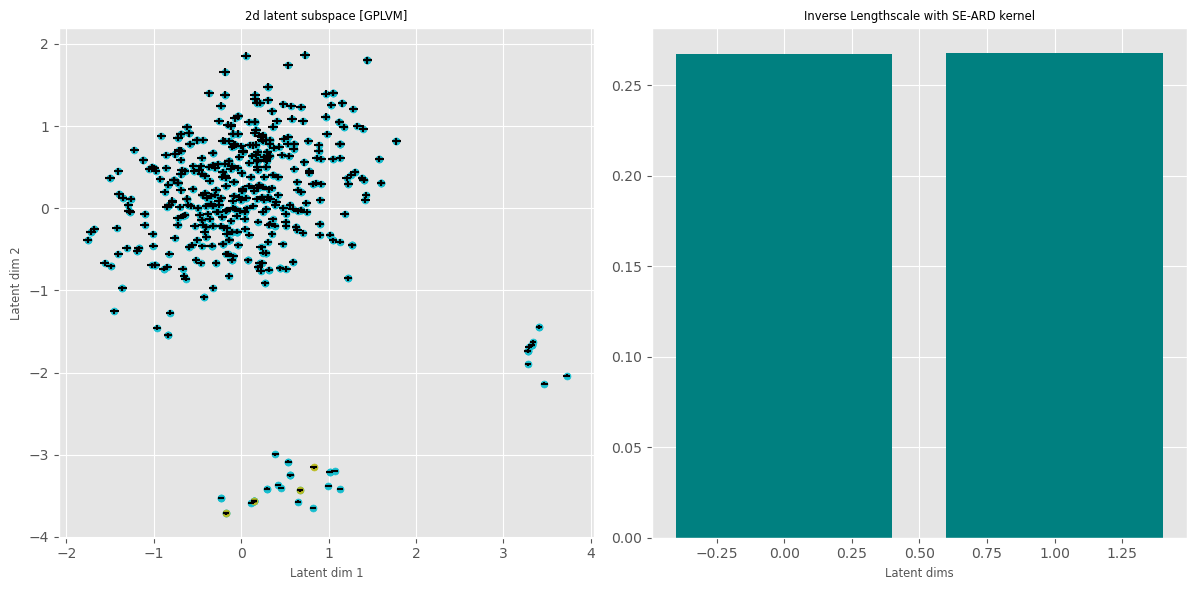

In [11]:
colors = plt.get_cmap("tab10").colors[::-1]
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.title(f"2d latent subspace [GPLVM]", fontsize="small")
plt.xlabel("Latent dim 1", fontsize="small")
plt.ylabel("Latent dim 2", fontsize="small")
# Select index of the smallest lengthscales by examining model.covar_module.base_kernel.lengthscales
for i, label in enumerate([0, 1]):
    X_i = X_train_mean[lb_train.numpy() == label]
    plt.scatter(X_i[:, l1], X_i[:, l2], c=[colors[i]], label=label, s=25)
    if X_train_scales is not None:
        scale_i = X_scales[lb_train.numpy() == label]
        plt.errorbar(
            X_i[:, l1],
            X_i[:, l2],
            xerr=scale_i[:, l1],
            yerr=scale_i[:, l2],
            label=label,
            c="black",
            fmt="none",
        )

plt.subplot(132)
plt.bar(
    np.arange(latent_dim),
    height=inv_lengthscale.detach().numpy().flatten(),
    color="teal",
)
plt.title("Inverse Lengthscale with SE-ARD kernel", fontsize="small")
plt.xlabel("Latent dims", fontsize="small")

# plt.subplot(133)
# plt.plot(losses,label='batch_size=100', color='orange')
# plt.xlabel('Steps', fontsize='small')
# plt.title('Neg. ELBO Loss', fontsize='small')

plt.tight_layout()

In [ ]:
model.save_output(Y_test)

In [ ]:
model.data_output